# Exploring Cancer Mortality Factors
S. Han and C. Chung On

# Acknowledgements
The purpose of this project is to replicate Dr. Martin Skarzynski's capstone project, which was completed using R, using Python. The capstone project is titled "Exploratory Analysis of Factors Associated with Cancer Mortality in the National Health and Nutrition Examination Survey Dataset," which was completed in partial fulfillment of Dr. Skarzynski's MPH degree from Johns Hopkins University School of Public Health.

One major modification from Dr. Skarzynski's capstone is that in this project, 50 potential predictor variables were chosen before inputing the data into a Cox Proportional Hazard Model instead of running thousands of hazard models. 

The capstone project, datasets used, and R codes can be found in the following link: https://github.com/marskar/nhanes.

## Background:
Although cancer mortality has been declining in the U.S., cancer is still the second leading cause of death. Susceptibility to cancer can be divided into modifiable and non-modifiable risk factors. Modifiable factors include body mass index (BMI) and cigarette use while non-modifiable factors include age, sex, and race/ethnicity. Data science methods can be utilized to run cancer risk prediction models, which can help find the factors most associated with cancer mortality risk. In this study, we used Python to analyze data from the Third National Health and Nutrition Examination Survey (NHANES III) and the National Death Index (NDI) Public-Use Linked Mortality Files. The goal of our analysis was to examine these datasets to identify variables associated with cancer mortality risk. 

## Methods: 
NHANES III consisted of interview, medical examination, and laboratory data sets. This data was collected from 1988 to 1994 in the United States. NHANES III was linked with mortality data from the NDI death records by the National Center for Health Statistics. 

### Methods Step 1: 
Read NHANES III and NDI datasets into pandas dataframes: (4 in total, labeled as: mort, lab, adult, and exam)

Note: When reading in csv files as pandas dataframes, python replaces blank cells (in csv) as blank strings of variable number of spaces (in dataframe). In order for python to convert all empty cells to NaN, we had to include the function 'skipinitialspace=True'. 

In [79]:
import pandas as pd
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.formula.api as smf


In [39]:
mort = pd.read_csv(r'C:\Users\hans11\Desktop\python_project\mort.csv', skipinitialspace=True)
lab = pd.read_csv(r'C:\Users\hans11\Desktop\python_project\lab.csv', skipinitialspace=True)
adult = pd.read_csv(r'C:\Users\hans11\Desktop\python_project\adult.csv', skipinitialspace=True, low_memory=False)
exam = pd.read_csv(r'C:\Users\hans11\Desktop\python_project\exam.csv', skipinitialspace=True, low_memory=False)

In [40]:
mort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33994 entries, 0 to 33993
Data columns (total 14 columns):
SEQN            33994 non-null int64
ELIGSTAT        33994 non-null object
MORTSTAT        33994 non-null object
CAUSEAVL        33994 non-null object
UCOD_LEADING    33994 non-null object
DIABETES        33994 non-null object
HYPERTEN        33994 non-null object
PERMTH_INT      19592 non-null float64
PERMTH_EXM      17738 non-null float64
MORTSRCE_NDI    6596 non-null object
MORTSRCE_CMS    3102 non-null object
MORTSRCE_SSA    5497 non-null object
MORTSRCE_DC     2492 non-null object
MORTSRCE_DCL    0 non-null float64
dtypes: float64(3), int64(1), object(10)
memory usage: 3.6+ MB


### Methods Step 2: 
Clean NDI dataset (mort):

    1) Only keep variables that are needed for study (i.e., SEQN, UCOD_LEADING, PERMTH_INT)
            * SEQN = unique identifier 
            * UCOD_LEADING = underlying cause of death recode from UCOD_113 (Leading causes)
            * PERMTH_INT = person months of follow-up from interview date 
    2) Remove entries with missing UCOD_LEADING or PERMTH_INT variables
    3) Create cancer mortality variable (cancer_mort) based on whether 'malignant neoplasms (COO-C97)'
    was recorded as cause of death (UCOD_LEADING) 
    4) Remove UCOD_LEADING from clean_mort dataframe (dataframe should not only have numerical data types) 

In [41]:
#1

mort_clean = mort[['SEQN', 'UCOD_LEADING', 'PERMTH_INT']]
mort_clean.info()

#33,994 entries; 3 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33994 entries, 0 to 33993
Data columns (total 3 columns):
SEQN            33994 non-null int64
UCOD_LEADING    33994 non-null object
PERMTH_INT      19592 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 796.8+ KB


In [42]:
#2: 

mort_clean = mort_clean[(mort_clean.UCOD_LEADING.notnull() & mort_clean.PERMTH_INT.notnull())]
mort_clean.info()

# 19,592 entries; 3 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19592 entries, 0 to 33990
Data columns (total 3 columns):
SEQN            19592 non-null int64
UCOD_LEADING    19592 non-null object
PERMTH_INT      19592 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 612.2+ KB


In [43]:
#3: create cancer_mort variable

def cancer_mort(mort_clean): 
    if mort_clean['UCOD_LEADING'] == 'Malignant neoplasms (C00-C97)':
        return 1
    else:
        return 0
mort_clean['cancer_mort'] = mort_clean.apply(cancer_mort, axis=1)

mort_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19592 entries, 0 to 33990
Data columns (total 4 columns):
SEQN            19592 non-null int64
UCOD_LEADING    19592 non-null object
PERMTH_INT      19592 non-null float64
cancer_mort     19592 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 765.3+ KB


In [44]:
#4: remove UCOD_LEADING
mort_clean = mort_clean.drop('UCOD_LEADING', axis=1)
mort_clean.info()

# 19,592 entries; 3 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19592 entries, 0 to 33990
Data columns (total 3 columns):
SEQN           19592 non-null int64
PERMTH_INT     19592 non-null float64
cancer_mort    19592 non-null int64
dtypes: float64(1), int64(2)
memory usage: 612.2 KB


### Methods Step 3:
Merge 4 dataframes together (df_merged) using SEQN

In [50]:
dfs = [mort_clean, lab, adult, exam]
df_merged = reduce(lambda left,right: pd.merge(left,right,on='SEQN'), dfs)
df_merged.info()

# df_merged = 17,738 entries; 3,962 columns 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17738 entries, 0 to 17737
Columns: 3962 entries, SEQN to PFPTECH
dtypes: float64(3644), int64(303), object(15)
memory usage: 536.3+ MB


#### Error: when dataframes were merged, duplicate variables were appended with _x or _y
    * Solution: Delete variables appended with _x or _y 

In [52]:
# removing columns that have _x in name

df_merged2 = df_merged.drop([col for col in df_merged.columns if '_x' in col], axis=1)
df_merged2.info()

# 17,738 entries; 3,800 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17738 entries, 0 to 17737
Columns: 3800 entries, SEQN to PFPTECH
dtypes: float64(3498), int64(287), object(15)
memory usage: 514.4+ MB


In [53]:
# removing columns that have _y in name

df_merged3 = df_merged2.drop([col for col in df_merged2.columns if '_y' in col], axis=1)
df_merged3.info()

# 17,738 entries; 3,638 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17738 entries, 0 to 17737
Columns: 3638 entries, SEQN to PFPTECH
dtypes: float64(3352), int64(271), object(15)
memory usage: 492.5+ MB


### Methods Step 4: Exclusion Criteria
The exclusion factors included participants who: 

    1) were under 18 years of age 
    2) had a self-reported cancer at baseline, and 
    3) had missing values for variables related to the study

In [54]:
# Exclusion Crtieria #1: 
    # HSAGEIR = age at interview
    
df_merged3.HSAGEIR.describe()
# Age range = 18-90 

count    17738.000000
mean        47.560886
std         20.221005
min         18.000000
25%         30.000000
50%         44.000000
75%         65.000000
max         90.000000
Name: HSAGEIR, dtype: float64

In [55]:
""" Exclusion Criteria #2: 
    HAC1N = 'doctor ever told you had: skin cancer'
    HAC1O = 'doctor ever told you had: other cancer'
        1 = Yes
        2 = No
        9 = Don't know
    Only keep those who answered 2 for HAC1N or HAC1O """ 

df_merged4 = df_merged3[(df_merged3.HAC1N == 2) & (df_merged3.HAC1O == 2)]
df_merged4.info()
#df_merged = 16,404 entries; 3,638 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16404 entries, 0 to 17737
Columns: 3638 entries, SEQN to PFPTECH
dtypes: float64(3352), int64(271), object(15)
memory usage: 455.4+ MB


In [56]:
# Exclusion Criteria #3: 
    # 15 variables with object type

object_list = list(df_merged4.select_dtypes(include=['object']).columns)
object_list

['PHPSNTI',
 'PHPDRTI',
 'PHPBEST',
 'HAJ12',
 'HAX18A',
 'HAX18B',
 'HAX18C',
 'HAZA1CC',
 'DEPSTLC1',
 'DEPSTLC2',
 'DEPSTLC3',
 'DEPSTLC4',
 'DEPSTLC5',
 'DEPSTLC6',
 'SPPTIME']

In [57]:
# all 15 variables that are object type are not necessary for study purposes
# delete these 15 variables from dataframe (df_merged)

df_merged5 = df_merged4.drop(['PHPSNTI','PHPDRTI','PHPBEST','HAJ12','HAX18A','HAX18B','HAX18C',
                             'HAZA1CC','DEPSTLC1','DEPSTLC2','DEPSTLC3','DEPSTLC4','DEPSTLC5',
                             'DEPSTLC6','SPPTIME'], axis=1)
df_merged5.info()
# 16,404 entries; 3,623 columns, all floats or ints

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16404 entries, 0 to 17737
Columns: 3623 entries, SEQN to PFPTECH
dtypes: float64(3352), int64(271)
memory usage: 453.6 MB


In [58]:
# Frequency table (crosstabs) using pandas pd.crosstab() function
# For cancer_mort outcome

cancer_mort_freq = pd.crosstab(index=df_merged5['cancer_mort'],
                              columns = 'count')
cancer_mort_freq

# 964 cancer deaths; 15,440 other deaths

col_0,count
cancer_mort,
0,15440
1,964


### Methods Step 5: Cleaning Dataset

    1. Remove variables with only one unique value
    2. Remove variables with more than 90% missing values (NaN)
    3. Remove variables that start with 'WTPQRP' (Fay's BRR Replicate weight for MEC-examined sample)
 

In [59]:
#1: remove variables with only one unique value: 

for col in df_merged5.columns:
    if len(df_merged5[col].unique()) == 1: 
        df_merged5.drop(col, inplace=True, axis=1)
        
df_merged5.info()

# 16,404 entries; 3,089 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16404 entries, 0 to 17737
Columns: 3089 entries, SEQN to PFPTECH
dtypes: float64(2822), int64(267)
memory usage: 386.7 MB


In [60]:
#2: select columns with more than 90% missing values (NaN) and delete: 

limitPer = len(df_merged5) * 0.90
df_merged6 = df_merged5.dropna(thresh=limitPer, axis=1)

df_merged6.info()

# 16,404 entries; 901 columns 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16404 entries, 0 to 17737
Columns: 901 entries, SEQN to BDPD0
dtypes: float64(634), int64(267)
memory usage: 112.9 MB


In [61]:
#3: delete columns that start with 'WTPQRP'
    # 'WTPQRP1 - WTPQRP52' = Fay's BRR Replicate weights for MEC- examined sample
    
for col in df_merged6.columns:
    if 'WTPQRP' in col:
        del df_merged6[col]

df_merged6.info()

# 16,404 entries; 849 columns 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16404 entries, 0 to 17737
Columns: 849 entries, SEQN to BDPD0
dtypes: float64(582), int64(267)
memory usage: 106.4 MB


### Methods Step 6: Finish cleaning dataset

    1) Calculate correlation (create correlation heat-map)
    2) Compare correlation between variables and remove those that have a correlation higher than 0.9
    3) Remove observations with missing value (NaN) in any of the columns 

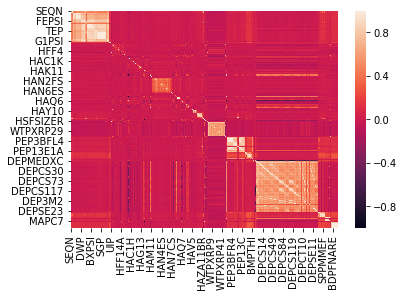

In [62]:
#1: generating correlation heat-map:

corr = df_merged6.corr()
sns.heatmap(corr) 

In [63]:
#2: compare correlation and remove those with correlation higher than 0.9

columns = np.full((corr.shape[0]), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = df_merged6.columns[columns]
df_merged7 = df_merged6[selected_columns]

df_merged7.info()

# 16,404 entries; 450 columns 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16404 entries, 0 to 17737
Columns: 450 entries, SEQN to BDPSCAN
dtypes: float64(200), int64(250)
memory usage: 56.4 MB


In [89]:
#3: delete entries with missing value (NaN) in any of the columns
# make all variables numeric type

df_merged8 = df_merged7.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df_merged8.apply(pd.to_numeric)
df_merged8.isna().sum().sum()
df_merged8.info()

# 10,242 entries; 450 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10242 entries, 0 to 17736
Columns: 450 entries, SEQN to BDPSCAN
dtypes: float64(200), int64(250)
memory usage: 35.2 MB


### Final Dataset: 

    1. 450 variables (includes SEQN, PERMTH_INT, and cancer_mort)
         a. All variables are either floats or integers
    2. 10,242 participants 
         a. 600 (59%) participants with a NDI file that indicated cancer as the leading cause of death
         b. Mean age: 44.7 yeas 

In [66]:
# final cancer_mort count after going through exclusion criteria

cancer_mort_freq = pd.crosstab(index=df_merged8['cancer_mort'],
                              columns = 'count')
cancer_mort_freq

col_0,count
cancer_mort,
0,9642
1,600


In [151]:
# Final dataset info: 

df_merged8.info()
df_merged8.HSAGEIR.mean()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10242 entries, 0 to 17736
Columns: 450 entries, SEQN to BDPSCAN
dtypes: float64(200), int64(250)
memory usage: 35.2 MB


44.745752782659636

In [74]:
# move cancer_mort column to end 

cols = list(df_merged8.columns.values)
cols.pop(cols.index('cancer_mort')) # remove cancer_mort from list
df_merged9 = df_merged8[cols + ['cancer_mort']] # create new dataframe with cancer_mort at the end

In [86]:
# pickle df_merged9 as df_final

import pickle
df_merged9.to_pickle('df_final')

In [87]:
# load pickled dataframe back as df_merged9

df_merged9 = pd.read_pickle('df_final')

### Analysis Steps: 

    1. Set cancer_mort and all other variables as their own dataframes (outcome and predictors, respectively)
    2. Randomly select 50 variables (set seed as 1993 for demonstration purpose) 
    3. Fit these 50 variables to a Cox proportional hazard model 
    4. Plot the hazard ratios (HR) and p-values (volcano plot) 

In [164]:
#1: Set outcome and predictors dataframes

outcome = df_merged9.iloc[:, -1]
predictors = df_merged9.iloc[:, 1:-1]

In [176]:
#2: Randomly select 50 variables from predictors dataframe
    # Seed is set to 1993 for demonstration purpose
        # This way, with every run, the same 50 variables are selected

df_random = predictors.columns.to_series().sample(50, random_state=1993)
random_vars = ' + '.join(list(df_random))

random_vars

'DEPCS7 + HAG33 + HAY11E + PEPLEVEL + HAL18 + HAS17 + HAE10 + HAK11 + HAV3S + DEPSE1 + BMPWT + HFF1 + WTPXRP36 + DEPRSFLG + HFHFIPCR + HAM6S + HAT28 + VCP + MOPPCNT + HAQ3S + HAK10 + HAK9 + HAN1C + SPPTECH1 + WTPFQX6 + DEPCS67 + HAR14 + HAN5AS + HFB1 + HAN4BS + HAQ7 + WTPXRP23 + HAM7 + HAC1F + HAP12 + WTPXRP19 + DEPCS72 + WTPXRP24 + HFINTVR + WTPXRP13 + HFA12 + WTPXRP15 + HAY11A + HFE3 + DEPSE9 + HAN2ES + HFF14A + HAN2GS + BMPWTFLG + PEP1'

In [178]:
#3: Cox proportional hazard model

mod = smf.phreg("PERMTH_INT ~ " + random_vars,
                predictors, status=outcome, ties="efron")

result = mod.fit()

In [ ]:
# Set hazard ratio results as 'hr' and p-value results as p-vals

result.summary().tables[1]

hr = result.summary().tables[1].loc[:,'HR']
pvals = result.summary().tables[1].loc[:,'P>|t|']

### Interpretation of Volcano Plot: (presented below) 

* Each point in the volcano plot represents the hazard ratio for one of the 50 predictor variables chosen. 
* The hazard ratios were found by fitting the predictor variables to a Cox proportional hazard model. 
* Variables are considered to be highly significant if their negative log10 p-values (y-axis) are above 10, 
  regardless of their hazard ratio (x-axis).
      
* As seen in the plot below, the majority (>90%) of the predictor variables have HRs centered around 1.0 and are not 
  highly significant. Having a HR of 1.0 signifies that the variable has a net neutral effect on the outcome. 
* This result is to be expected from choosing 50 random variables from a list of 450 variables that were **not** collected with the purpose of predicting cancer mortality. 
  
#####  However, among the 50 predictor variables that were chosen with the seed 1993, the two variables that were found to be highly significant are both age-related variables. 
1. HAM7 (Age of participant): [far right]
    * Code: 1 = 25 years or less; 2 = 26-35 years old; 3 = 36 years and older
    * HR = 3.1170, p<0.0001
    * Older age is strongly associated with the risk of cancer mortality. 
2. HAQ7 (Age of participant): [far left]
    * Code: 1 = 50+ years; 2 = Under 50 years
    * HR = 0.2791, p<0.0001
    * Older age is strongly associated with the risk of cancer mortality. 

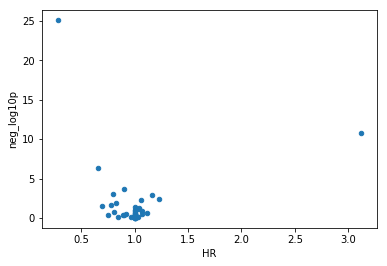

In [183]:
# Plot hazard ratios and p-values (volcano plot)

df = result.summary().tables[1]
pvals = result.summary().tables[1].loc[:,'P>|t|']
df = df.assign(neg_log10p=-np.log10(pvals))
ax = df.plot(kind='scatter', x='HR', y='neg_log10p')
ax.set_xlim()
fig = ax.get_figure()
fig.savefig('volc.png')